In [79]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas

import pandas_ta as ta
from fastai.tabular.all import add_datepart

import datetime
from dateutil.relativedelta import relativedelta

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.metrics import mean_absolute_error

import trade


## Initializations

In [80]:
ticker = 'NVDA'

outfile = ('./Resources/' + str(ticker) +'_out.csv') # output data for review

stock_data_period = '4y'
stock_data_interval = '1d'

sma_short = 4
sma_long = 50
sma_period = 20
bbands_period = 20
macd_fast = 8
macd_slow = 21

share_size = 100
initial_capital = 5000

___
## Get live data

In [4]:
# Get live stock data
stock_df = pd.DataFrame()
stock_df = stock_df.ta.ticker(ticker, period = stock_data_period, interval = stock_data_interval)
stock_df.drop(columns=['Dividends', 'Stock Splits'],inplace=True,axis=1)
stock_df

,Open,High,Low,Close,Volume
Date,,,,,
2018-10-04,70.742268,70.985294,68.488098,69.259331,39122000
2018-10-05,69.011352,69.633786,66.345529,66.920845,42663600
2018-10-08,66.087616,67.243221,64.495559,65.906586,40861200
2018-10-09,65.700764,66.648063,65.170076,65.849556,27350000
2018-10-10,64.788184,65.246947,60.904761,60.927078,68494000
...,...,...,...,...,...
2022-09-27,125.070000,127.360001,122.580002,124.129997,55385400
2022-09-28,124.099998,128.229996,123.540001,127.360001,54241400
2022-09-29,124.480003,125.000000,119.459999,122.199997,53276300


<AxesSubplot:xlabel='Date'>

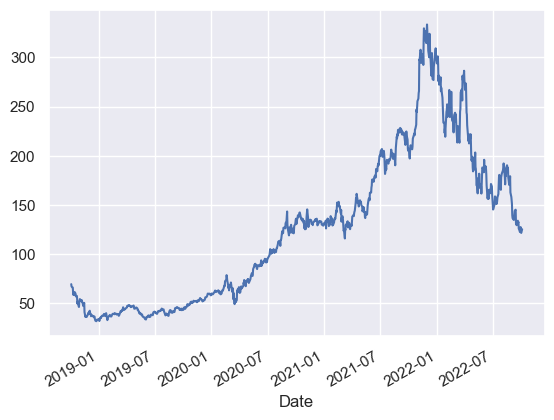

In [37]:
#Plot the True Adj Close Value
stock_df['Close'].plot()

In [81]:
df = stock_df.copy()     # reload copy of df here instead of downloading

---
## Machine Learning - XGBoost

#### Add features

In [82]:
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 4,50, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": sma_long},
        {"kind": "sma", "length": sma_short},
        {"kind": "bbands", "length": bbands_period},
        {"kind": "rsi"},
        {"kind": "macd", "fast": macd_fast, "slow": macd_slow},
        {"kind": "sma", "close": "volume", "length": sma_period, "prefix": "VOLUME"},
    ]
)
# Run "Custom Strategy" to add additional features/columns to dataframe.
df.ta.strategy(CustomStrategy)

In [83]:
df['Actual Returns'] = df['Close'].pct_change()
df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']]=df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']].shift(-1)
df.head()

,Open,High,Low,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20,Actual Returns
Date,,,,,,,,,,,,,,,,,,
2018-10-04,70.742268,70.985294,68.488098,66.920845,39122000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-05,69.011352,69.633786,66.345529,65.906586,42663600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.033764
2018-10-08,66.087616,67.243221,64.495559,65.849556,40861200,NaN,66.984079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015156
2018-10-09,65.700764,66.648063,65.170076,60.927078,27350000,NaN,64.901016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000865
2018-10-10,64.788184,65.246947,60.904761,58.308369,68494000,NaN,62.747897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.074753


#### Generate Trading Signal

In [84]:
# Generate buy/sell signal
df['Signal'] = 0.0
# Generate signal to buy stock
df.loc[(df['Actual Returns'] >= 0), 'Signal'] = 1
# Generate signal to sell stock
df.loc[(df['Actual Returns'] < 0), 'Signal'] = 0

In [85]:
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20,Actual Returns,Signal
0,2018-10-04,70.742268,70.985294,68.488098,66.920845,39122000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2018-10-05,69.011352,69.633786,66.345529,65.906586,42663600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.033764,0.0
2,2018-10-08,66.087616,67.243221,64.495559,65.849556,40861200,NaN,66.984079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015156,0.0
3,2018-10-09,65.700764,66.648063,65.170076,60.927078,27350000,NaN,64.901016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000865,0.0
4,2018-10-10,64.788184,65.246947,60.904761,58.308369,68494000,NaN,62.747897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.074753,0.0


## Add date related features/coumns to dataframe

In [86]:
add_datepart(df, 'Date', drop=False)

,Date,Open,High,Low,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2018-10-04,70.742268,70.985294,68.488098,66.920845,39122000,NaN,NaN,NaN,NaN,...,4,3,277,False,False,False,False,False,False,1.538611e+09
1,2018-10-05,69.011352,69.633786,66.345529,65.906586,42663600,NaN,NaN,NaN,NaN,...,5,4,278,False,False,False,False,False,False,1.538698e+09
2,2018-10-08,66.087616,67.243221,64.495559,65.849556,40861200,NaN,66.984079,NaN,NaN,...,8,0,281,False,False,False,False,False,False,1.538957e+09
3,2018-10-09,65.700764,66.648063,65.170076,60.927078,27350000,NaN,64.901016,NaN,NaN,...,9,1,282,False,False,False,False,False,False,1.539043e+09
4,2018-10-10,64.788184,65.246947,60.904761,58.308369,68494000,NaN,62.747897,NaN,NaN,...,10,2,283,False,False,False,False,False,False,1.539130e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2022-09-27,125.070000,127.360001,122.580002,127.360001,55385400,160.266131,124.732500,119.146427,133.690660,...,27,1,270,False,False,False,False,False,False,1.664237e+09
1002,2022-09-28,124.099998,128.229996,123.540001,122.199997,54241400,159.149789,123.992498,119.198003,132.255902,...,28,2,271,False,False,False,False,False,False,1.664323e+09
1003,2022-09-29,124.480003,125.000000,119.459999,121.389999,53276300,157.968661,123.769999,117.909075,131.358972,...,29,3,272,False,False,False,False,False,False,1.664410e+09
1004,2022-09-30,120.870003,126.330002,120.750000,125.120003,56486900,157.008290,124.017500,117.292992,130.793499,...,30,4,273,True,False,True,False,False,False,1.664496e+09


In [87]:
# Drop irrelevant columns
df.drop(columns=['Open', 'High', 'Low', 'Year'],inplace=True,axis=1)

In [88]:
df=df.iloc[51:]
df=df.iloc[:-1]
df.head()

,Date,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
51,2018-12-18,34.382568,56437200,46.903303,35.713089,33.963530,37.630615,41.297701,19.489903,0.057135,...,18,1,352,False,False,False,False,False,False,1.545091e+09
52,2018-12-19,33.536095,74536400,46.257034,35.008731,33.385229,37.458951,41.532673,21.750327,0.018517,...,19,2,353,False,False,False,False,False,False,1.545178e+09
53,2018-12-20,32.163380,74958800,45.681760,34.139302,32.628457,37.272835,41.917213,24.920980,-0.050069,...,20,3,354,False,False,False,False,False,False,1.545264e+09
54,2018-12-21,31.545284,86374000,45.146498,32.906832,31.799546,37.052219,42.304891,28.352810,-0.024203,...,21,4,355,False,False,False,False,False,False,1.545350e+09
55,2018-12-24,33.039642,46384000,44.584534,32.571100,31.292286,36.806507,42.320727,29.963290,0.158441,...,24,0,358,False,False,False,False,False,False,1.545610e+09


In [89]:
df=df.set_index(['Date'])

___
## Calculate P&L and ROI based on trading signal

In [90]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
pl_df = df[['Close', 'Signal']].copy()
pl_df['Entry/Exit'] = pl_df['Signal'].diff()
pl_df.head()


,Close,Signal,Entry/Exit
Date,,,
2018-12-18,34.382568,1.0,NaN
2018-12-19,33.536095,0.0,-1.0
2018-12-20,32.163380,0.0,0.0
2018-12-21,31.545284,0.0,0.0
2018-12-24,33.039642,0.0,0.0


In [91]:
pl_df['Entry/Exit'].value_counts()

 0.0    458
-1.0    248
 1.0    247
Name: Entry/Exit, dtype: int64

In [92]:
# Visualize entry position relative to close price
entry = pl_df[pl_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = pl_df[pl_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = pl_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + 'Entry and Exit Points')
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Backtest trading strategy

#### Execute trades based on the entry/exit signals and calculate P&L

In [93]:
pl_df, accumulated_shares = trade.gain_loss(pl_df, share_size)

In [94]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = pl_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $3,226.09
The trading algorithm resulted in a return on investment of 64.52%


#### Calculate and plot porfolio value

In [95]:
pl_df = trade.calc_portfolio_value(pl_df, share_size, initial_capital)
pl_df.head()

,Close,Signal,Entry/Exit,trade_type,cost/proceeds,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2018-12-18,34.382568,1.0,NaN,hold,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-19,33.536095,0.0,-1.0,hold,NaN,0.0,-100.0,-3353.609467,8353.609467,5000.000000,NaN,NaN
2018-12-20,32.163380,0.0,0.0,hold,NaN,0.0,0.0,-3216.337967,8353.609467,5137.271500,0.027454,0.027454
2018-12-21,31.545284,0.0,0.0,hold,NaN,0.0,0.0,-3154.528427,8353.609467,5199.081039,0.012032,0.039816
2018-12-24,33.039642,0.0,0.0,hold,NaN,0.0,0.0,-3303.964233,8353.609467,5049.645233,-0.028743,0.009929


In [53]:
# Visualize exit positions relative to total portfolio value
entry = pl_df[pl_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize entry positions relative to total portfolio value
exit = pl_df[pl_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the total portoflio value for the investment
total_portfolio_value = pl_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title=(ticker + ' - Total Portfolio Value'),
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

#### Show the portfolio evaluation metrics

In [78]:
# Review the portfolio evaluation DataFrame
portfolio_metrics =trade.portfolio_metrics(pl_df)

KeyError: 'Portfolio Daily Returns'

In [58]:
print(f"The Annualized Return is {portfolio_metrics['Backtest'][0]*100:,.2f}%")

print(f"The Cummulative Return is {portfolio_metrics['Backtest'][1]*100:,.2f}%")

print(f"The Annual Volatility is {portfolio_metrics['Backtest'][2]:,.2f}")

print(f"The Sharpe Ratio is {portfolio_metrics['Backtest'][3]:,.2f}")

print(f"The Sortino Ratio is {portfolio_metrics['Backtest'][4]:,.2f}")

NameError: name 'portfolio_metrics' is not defined

---
## Machine Learning

#### Extract features and target

In [59]:
# Extract features 
X = df.drop(columns=['Actual Returns', 'Signal'])
X.head()

,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-18,34.382568,56437200,46.903303,35.713089,33.963530,37.630615,41.297701,19.489903,0.057135,32.640923,...,18,1,352,False,False,False,False,False,False,1.545091e+09
2018-12-19,33.536095,74536400,46.257034,35.008731,33.385229,37.458951,41.532673,21.750327,0.018517,31.171661,...,19,2,353,False,False,False,False,False,False,1.545178e+09
2018-12-20,32.163380,74958800,45.681760,34.139302,32.628457,37.272835,41.917213,24.920980,-0.050069,28.899792,...,20,3,354,False,False,False,False,False,False,1.545264e+09
2018-12-21,31.545284,86374000,45.146498,32.906832,31.799546,37.052219,42.304891,28.352810,-0.024203,27.913298,...,21,4,355,False,False,False,False,False,False,1.545350e+09
2018-12-24,33.039642,46384000,44.584534,32.571100,31.292286,36.806507,42.320727,29.963290,0.158441,33.797130,...,24,0,358,False,False,False,False,False,False,1.545610e+09


In [60]:
# Extract target
y = df['Signal']

y.value_counts()

1.0    516
0.0    438
Name: Signal, dtype: int64

#### Split train - test data

In [61]:
training_begin = X.index.min() + DateOffset(months=14)
training_end = X.index.max() - DateOffset(months=5)
print(training_begin)
print(training_end) 

2020-02-18 00:00:00
2022-04-30 00:00:00


In [62]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [63]:
# Scale the features data

scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(556, 26) (556,)
(106, 26) (106,)


In [64]:
# Use RandomOverSampler to resample the dataset using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
print(len(X_resampled))
print(len(y_resampled))

602
602


#### Train machine learning model using XGBoost

In [65]:
# Instantiate model using XGBClassifier
model = xgb.XGBClassifier()

# Fit/train the model
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict trading signals
training_signal_predictions = model.predict(X_resampled)

In [66]:
# Print classification report on training dataset
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       301
         1.0       1.00      1.00      1.00       301

    accuracy                           1.00       602
   macro avg       1.00      1.00      1.00       602
weighted avg       1.00      1.00      1.00       602



In [67]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
testing_report = classification_report(y_test, testing_signal_predictions)

print(testing_report)


              precision    recall  f1-score   support

         0.0       0.60      0.78      0.68        54
         1.0       0.67      0.46      0.55        52

    accuracy                           0.62       106
   macro avg       0.63      0.62      0.61       106
weighted avg       0.63      0.62      0.61       106



In [68]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['Predicted Signal'] = testing_signal_predictions

# Add in actual returns and calculate trading returns
predictions_df['Actual Returns'] = df['Actual Returns']
predictions_df['ML Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted Signal']
predictions_df.tail(20)


,Predicted Signal,Actual Returns,ML Returns
Date,,,
2022-09-02,1,-0.020808,-0.020808
2022-09-06,1,-0.013336,-0.013336
2022-09-07,1,0.018795,0.018795
2022-09-08,0,0.020125,0.000000
2022-09-09,0,0.028377,0.000000
2022-09-12,0,0.008202,0.000000
2022-09-13,0,-0.094726,-0.000000
2022-09-14,0,-0.000228,-0.000000
2022-09-15,0,-0.015158,-0.000000


<AxesSubplot:xlabel='Date'>

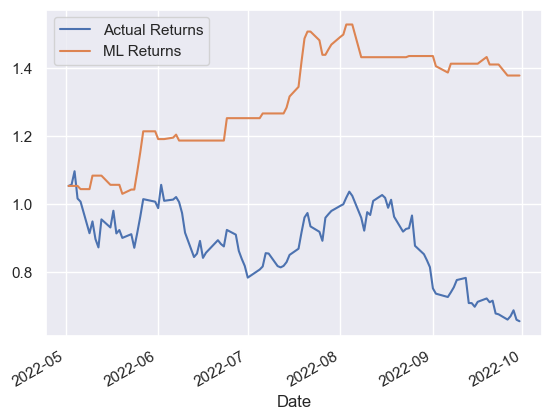

In [69]:
# Calculate and plot the cumulative returns for the `Actual Returns` and the `Algo Returns`
(1 + predictions_df[['Actual Returns', 'ML Returns']]).cumprod().plot()

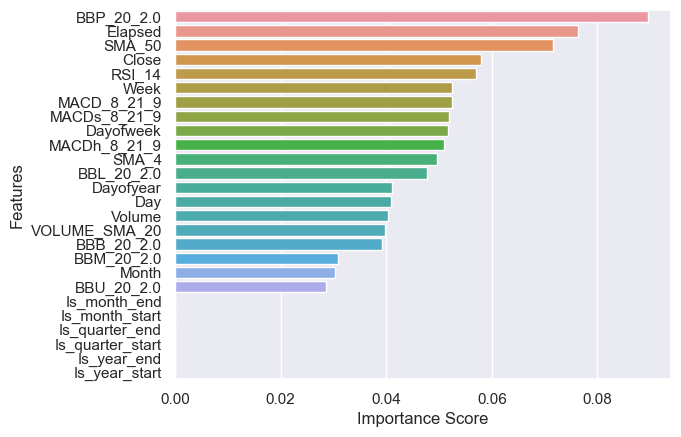

In [70]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

___
## Calculate P&L and ROI based on ML predicted trading signal

In [72]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
predictions_df['Close'] = df['Close']
predictions_df


,Predicted Signal,Actual Returns,ML Returns,Close
Date,,,,
2022-05-02,1,0.053162,0.053162,195.920364
2022-05-03,0,0.003533,0.000000,203.236618
2022-05-04,0,0.037343,0.000000,188.344208
2022-05-05,0,-0.073276,-0.000000,186.655060
2022-05-06,1,-0.008968,-0.008968,169.413834
...,...,...,...,...
2022-09-26,1,-0.023011,-0.023011,124.129997
2022-09-27,0,0.015129,0.000000,127.360001
2022-09-28,0,0.026021,0.000000,122.199997


In [73]:
pl_df = predictions_df[['Close', 'Predicted Signal']].copy()
pl_df['Entry/Exit'] = pl_df['Predicted Signal'].diff()
pl_df.head()

,Close,Predicted Signal,Entry/Exit
Date,,,
2022-05-02,195.920364,1,NaN
2022-05-03,203.236618,0,-1.0
2022-05-04,188.344208,0,0.0
2022-05-05,186.655060,0,0.0
2022-05-06,169.413834,1,1.0


In [74]:
pl_df['Entry/Exit'].value_counts()

 0.0    70
-1.0    18
 1.0    17
Name: Entry/Exit, dtype: int64

In [77]:
# Call function to calculate P&L
pl_df, accumulated_shares = trade.gain_loss(pl_df, share_size)

# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = pl_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $-698.31
The trading algorithm resulted in a return on investment of -13.97%
